In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from time import time

In [2]:
# defining a DeepRitz block: f_i(s) = ϕ(Wi2 . ϕ(Wi1 . s +bi1) + bi2) + s
class DeepRitz_block(nn.Module):
    def __init__(self, h_size):
        super(DeepRitz_block, self).__init__()
        self.dim_h = h_size

        self.activation_function = nn.ReLU()
        block = [nn.Linear(self.dim_h, self.dim_h),
                 self.activation_function,
                 nn.Linear(self.dim_h, self.dim_h),
                 self.activation_function]
        self._block = nn.Sequential(*block)
    def forward(self, x):
        return self._block(x) + x

# defining the neural network constructed by DeepRitz blocks
class Neural_Network(nn.Module):
    def __init__(self, neighbor_size=10, h_size = 10, block_size = 1, dev="cpu"):
        super(Neural_Network, self).__init__()
        self.in_size = neighbor_size * 2 + 1
        self.num_blocks = block_size
        self.dim_h = h_size
        self.dev = dev
        
        self.neighbor_size = neighbor_size
        self.pad_input = nn.ConstantPad2d((self.neighbor_size-1, self.neighbor_size-1,0, 0), 0.)
        self.pad_result= nn.ConstantPad3d((0, 0, 1, 1, 0, 0), 0.)

        self._block0 = DeepRitz_block(self.dim_h)
        self._block = DeepRitz_block(self.dim_h)
        
        model0 = [nn.ConstantPad1d((0, self.dim_h - 1), 0)]
        for _ in range(3): model0.append(self._block0)
        self.fe = nn.Sequential(*model0)
        
        model = []
        for _ in range(self.num_blocks): model.append(self._block)
        model.append(nn.Linear(self.dim_h, 2, bias=False))
        self.fg = nn.Sequential(*model)

# defining the ASEP model with open boundary condition
class Model(nn.Module):
    def __init__(self, batch_size, num_lattice, cutoff_dist, GNN, dev):
        super().__init__()
        self.dev = dev
        self.batch_size = batch_size
        self.cutoff_dist = cutoff_dist
        self.lattice_size = num_lattice
        self.lattice, self.padding_l, self.padding_r = self._init_lattice(batch_size, num_lattice)
        
        self.diff = torch.arange(self.lattice_size+1*2).to(self.dev)
        self.diff = self.diff[None,:] - self.diff[:,None] 
        
        self.cutoff_mat = self._init_cutoff_mat()
        
        self.GNN = GNN.to(dev)
        
    def _init_cutoff_mat(self):
        cutoff_mat = torch.zeros(self.lattice_size, self.lattice_size + 2)
        for i in range(self.lattice_size):
            left = np.maximum(i+1-self.cutoff_dist, 0)
            right = np.minimum(i+1+self.cutoff_dist, self.lattice_size + 1)
            cutoff_mat[i, left:right+1] = 1
        return cutoff_mat.to(self.dev)
        
    def _init_lattice(self, batch_size, num_lattice):
        lattice = torch.tensor(np.random.choice([0.,1.],[batch_size, num_lattice + 2]), 
                               device=self.dev).float()
        lattice[:,0] = 0.
        lattice[:,-1] = 0.
    
        padding_left = lattice * 0.
        padding_right = lattice * 0.
        padding_left[:,0] = 1
        padding_right[:,-1] = 1
    
        return lattice, padding_left, padding_right
    
    def reset_lattice(self):
        self.lattice, _, _ = self._init_lattice(self.batch_size, self.lattice_size)
        
    # compute the control force
    def controlled_rate(self):
        dx = torch.einsum('...j, ij->...ij', self.lattice + self.padding_r + self.padding_l, asep.diff)
        f = torch.einsum('...ijk,ij->...ijk', self.GNN.fe(dx[:,1:-1,:,None]), self.cutoff_mat)
        f = self.GNN.fg(f.sum(-2)) * self.lattice[:,1:-1].unsqueeze(-1)
        return self.GNN.pad_result(f)

    # Gillespie
    def forward(self, STEPS, p, q, alpha, beta, gamma, delta, control=False):
        jump_size = torch.eye(self.lattice.shape[1], device=dev)
        boundary_rate_l = torch.zeros_like(self.lattice)
        boundary_rate_r = torch.zeros_like(self.lattice)
        boundary_rate_l[:,1]  = gamma - q
        boundary_rate_r[:,-2] = beta - p
        
        trajectory = torch.zeros([STEPS, *self.lattice.shape])
        trajectory[0] = self.lattice
        
        current = torch.zeros(STEPS, self.batch_size, device=self.dev)
        KL = torch.zeros(STEPS, self.batch_size, device=self.dev)
        
        batch_list = torch.arange(self.batch_size, device=self.dev)
        time = torch.zeros(STEPS, self.batch_size, device=self.dev)

        for step in range(STEPS):
            rate_0 = torch.stack([self.lattice * (q+boundary_rate_l) + self.padding_r * delta,
                                  self.lattice * (p+boundary_rate_r) + self.padding_l * alpha], -1)
            rate_c = self.controlled_rate()
            
            rate = torch.abs(rate_c + rate_0)  if control else rate_0
            
            # sampling waiting time
            dt = -torch.log(torch.rand(self.batch_size, device=self.dev)) / rate.sum(axis=(1,2))
            
            # sampling reactions
            u_par = torch.multinomial(rate.sum(-1), 1).flatten()
            u_dir = torch.multinomial(rate[batch_list, u_par], 1).flatten()
            u_nex = (u_par + 2*u_dir-1).long()

            # reaction occurs when the next location is empty
            if_occupied = self.lattice[batch_list, u_nex]
            self.lattice = self.lattice - (jump_size[u_par] + jump_size[u_nex]) * if_occupied[:,None]
            
            self.lattice = self.lattice * (1-self.padding_l) * (1-self.padding_r)
            
            W  =  rate[batch_list, u_par, u_dir]
            W0 = rate_0[batch_list, u_par, u_dir]
            KL[step] = (1 - if_occupied) * (W0 - W + W * torch.log(W/W0 + 1e-14)) * dt
            current[step] = (1 - if_occupied) * (u_nex - u_par)
            trajectory[step] = self.lattice
            time[step] = dt
            
        return time, trajectory, current, KL

In [5]:
dev = "cuda:0" if torch.cuda.is_available() else "cpu"
print(dev)

batch_size = 8000
lattice_size = 10
cutoff_dist = 10

p, q, alpha, beta, gamma, delta = .1, .9, .5, 0.5, 0.5, .5
GNN = Neural_Network(h_size = 20, block_size = 2).to(dev)
asep = Model(batch_size, lattice_size, cutoff_dist, GNN, dev)

Lambda = []
K = []
A = []

cuda:0


In [6]:
optimizer = torch.optim.Adagrad(asep.GNN.parameters(), lr = 1e-2)

In [7]:
biasing = -.3
STEPS = 2
for training_step in range(2000):
    st = time()

    optimizer.zero_grad()
    t, _, current, KL = asep(STEPS, p, q, alpha, beta, gamma, delta, control=True)
    
    K_T = KL.sum(0) / ( t.sum(0))
    A_T = current.sum(0) / ( t.sum(0)) 
    
    loss = (K_T - biasing * 1 * A_T) / lattice_size
    loss.mean().backward()
    
    isnan = False
    for para in asep.GNN.parameters():
        if torch.isnan(para.grad).sum() > 0:
            isnan = True
            break
    if isnan:
        raise Exception('NaN!')
            
    optimizer.step()
    
    with torch.no_grad():          
        Lambda.append(loss.cpu().detach().numpy())
        K.append(K_T.cpu().detach().numpy())
        A.append(A_T.cpu().detach().numpy())
        if (training_step+1) % 1 == 0: 
            print('step: %i --- time: %.2f --- %.4f - %.2f * %.4f = %.4f'%
                  (training_step+1, time()-st, K[-1].mean(), biasing, A[-1].mean(), Lambda[-1].mean()))

step: 1 --- time: 0.05 --- 3.3654 - -0.30 * 6.2060 = 0.4752
step: 2 --- time: 0.04 --- 0.6584 - -0.30 * -2.7928 = -0.0163
step: 3 --- time: 0.04 --- 0.1198 - -0.30 * -5.8766 = -0.1494
step: 4 --- time: 0.04 --- 0.7007 - -0.30 * -8.7458 = -0.1748
step: 5 --- time: 0.04 --- 0.8467 - -0.30 * -6.5648 = -0.1021
step: 6 --- time: 0.04 --- 0.7387 - -0.30 * -5.3386 = -0.0784
step: 7 --- time: 0.04 --- 0.6054 - -0.30 * -5.3082 = -0.0897
step: 8 --- time: 0.04 --- 0.5496 - -0.30 * -5.1200 = -0.0897
step: 9 --- time: 0.04 --- 0.5212 - -0.30 * -5.0883 = -0.0914
step: 10 --- time: 0.04 --- 0.4933 - -0.30 * -5.5645 = -0.1069
step: 11 --- time: 0.04 --- 0.5293 - -0.30 * -5.5577 = -0.1035
step: 12 --- time: 0.04 --- 0.5374 - -0.30 * -5.2792 = -0.0951
step: 13 --- time: 0.04 --- 0.5160 - -0.30 * -5.7329 = -0.1094
step: 14 --- time: 0.04 --- 0.5568 - -0.30 * -4.7648 = -0.0793
step: 15 --- time: 0.04 --- 0.4890 - -0.30 * -4.7667 = -0.0856
step: 16 --- time: 0.04 --- 0.4573 - -0.30 * -4.6452 = -0.0851
ste

step: 133 --- time: 0.04 --- 0.3246 - -0.30 * -3.5594 = -0.0676
step: 134 --- time: 0.04 --- 0.3131 - -0.30 * -3.5938 = -0.0696
step: 135 --- time: 0.04 --- 0.3145 - -0.30 * -3.6671 = -0.0714
step: 136 --- time: 0.04 --- 0.3097 - -0.30 * -3.4475 = -0.0659
step: 137 --- time: 0.04 --- 0.3038 - -0.30 * -3.6801 = -0.0728
step: 138 --- time: 0.04 --- 0.3075 - -0.30 * -3.5349 = -0.0684
step: 139 --- time: 0.04 --- 0.3129 - -0.30 * -3.7327 = -0.0734
step: 140 --- time: 0.04 --- 0.3257 - -0.30 * -3.3450 = -0.0616
step: 141 --- time: 0.04 --- 0.2888 - -0.30 * -3.6032 = -0.0720
step: 142 --- time: 0.04 --- 0.3154 - -0.30 * -3.7416 = -0.0734
step: 143 --- time: 0.04 --- 0.3205 - -0.30 * -3.2659 = -0.0599
step: 144 --- time: 0.04 --- 0.2879 - -0.30 * -3.5974 = -0.0719
step: 145 --- time: 0.04 --- 0.2955 - -0.30 * -3.8157 = -0.0772
step: 146 --- time: 0.04 --- 0.3212 - -0.30 * -4.0140 = -0.0803
step: 147 --- time: 0.04 --- 0.3385 - -0.30 * -3.8287 = -0.0736
step: 148 --- time: 0.04 --- 0.3421 - -0

step: 265 --- time: 0.04 --- 0.3076 - -0.30 * -3.3147 = -0.0624
step: 266 --- time: 0.04 --- 0.2899 - -0.30 * -3.4686 = -0.0682
step: 267 --- time: 0.04 --- 0.3040 - -0.30 * -3.5283 = -0.0686
step: 268 --- time: 0.04 --- 0.2993 - -0.30 * -3.9709 = -0.0811
step: 269 --- time: 0.04 --- 0.3551 - -0.30 * -4.8972 = -0.1013
step: 270 --- time: 0.04 --- 0.4561 - -0.30 * -4.1800 = -0.0725
step: 271 --- time: 0.04 --- 0.3815 - -0.30 * -3.4103 = -0.0583
step: 272 --- time: 0.04 --- 0.3240 - -0.30 * -3.8220 = -0.0748
step: 273 --- time: 0.04 --- 0.3376 - -0.30 * -3.2145 = -0.0570
step: 274 --- time: 0.04 --- 0.2897 - -0.30 * -3.3093 = -0.0639
step: 275 --- time: 0.04 --- 0.2961 - -0.30 * -3.8787 = -0.0789
step: 276 --- time: 0.04 --- 0.3336 - -0.30 * -4.1756 = -0.0836
step: 277 --- time: 0.04 --- 0.3807 - -0.30 * -3.7395 = -0.0674
step: 278 --- time: 0.04 --- 0.3306 - -0.30 * -3.6199 = -0.0687
step: 279 --- time: 0.04 --- 0.3349 - -0.30 * -3.5914 = -0.0675
step: 280 --- time: 0.04 --- 0.3117 - -0

step: 397 --- time: 0.04 --- 0.3570 - -0.30 * -3.6460 = -0.0670
step: 398 --- time: 0.04 --- 0.3317 - -0.30 * -3.7128 = -0.0711
step: 399 --- time: 0.04 --- 0.3346 - -0.30 * -3.5327 = -0.0659
step: 400 --- time: 0.04 --- 0.3258 - -0.30 * -3.7768 = -0.0734
step: 401 --- time: 0.04 --- 0.3358 - -0.30 * -3.1381 = -0.0551
step: 402 --- time: 0.04 --- 0.2879 - -0.30 * -3.2984 = -0.0638
step: 403 --- time: 0.04 --- 0.2896 - -0.30 * -3.4516 = -0.0678
step: 404 --- time: 0.04 --- 0.2996 - -0.30 * -3.6725 = -0.0729
step: 405 --- time: 0.04 --- 0.3273 - -0.30 * -3.4058 = -0.0631
step: 406 --- time: 0.04 --- 0.3045 - -0.30 * -3.4287 = -0.0658
step: 407 --- time: 0.04 --- 0.3009 - -0.30 * -3.8766 = -0.0784
step: 408 --- time: 0.04 --- 0.3444 - -0.30 * -3.4814 = -0.0636
step: 409 --- time: 0.04 --- 0.3143 - -0.30 * -3.3137 = -0.0618
step: 410 --- time: 0.04 --- 0.2944 - -0.30 * -3.5396 = -0.0698
step: 411 --- time: 0.04 --- 0.3163 - -0.30 * -4.0439 = -0.0815
step: 412 --- time: 0.04 --- 0.3552 - -0

step: 529 --- time: 0.04 --- 0.3400 - -0.30 * -3.7161 = -0.0704
step: 530 --- time: 0.04 --- 0.3384 - -0.30 * -3.4723 = -0.0639
step: 531 --- time: 0.04 --- 0.3117 - -0.30 * -3.5952 = -0.0697
step: 532 --- time: 0.04 --- 0.3240 - -0.30 * -3.5898 = -0.0685
step: 533 --- time: 0.04 --- 0.3231 - -0.30 * -3.8344 = -0.0752
step: 534 --- time: 0.04 --- 0.3627 - -0.30 * -3.9311 = -0.0742
step: 535 --- time: 0.04 --- 0.3651 - -0.30 * -3.7180 = -0.0682
step: 536 --- time: 0.04 --- 0.3436 - -0.30 * -3.3737 = -0.0608
step: 537 --- time: 0.04 --- 0.3004 - -0.30 * -3.2483 = -0.0613
step: 538 --- time: 0.04 --- 0.2895 - -0.30 * -3.3803 = -0.0659
step: 539 --- time: 0.04 --- 0.3038 - -0.30 * -3.4539 = -0.0666
step: 540 --- time: 0.04 --- 0.3040 - -0.30 * -3.3483 = -0.0637
step: 541 --- time: 0.04 --- 0.3055 - -0.30 * -3.4538 = -0.0664
step: 542 --- time: 0.04 --- 0.3070 - -0.30 * -3.7847 = -0.0753
step: 543 --- time: 0.04 --- 0.3456 - -0.30 * -3.7996 = -0.0722
step: 544 --- time: 0.04 --- 0.3475 - -0

step: 661 --- time: 0.04 --- 0.3153 - -0.30 * -3.5377 = -0.0678
step: 662 --- time: 0.04 --- 0.3329 - -0.30 * -3.5533 = -0.0666
step: 663 --- time: 0.04 --- 0.3204 - -0.30 * -3.4758 = -0.0657
step: 664 --- time: 0.04 --- 0.3186 - -0.30 * -4.0840 = -0.0824
step: 665 --- time: 0.04 --- 0.3944 - -0.30 * -3.3569 = -0.0557
step: 666 --- time: 0.04 --- 0.2961 - -0.30 * -3.3202 = -0.0636
step: 667 --- time: 0.04 --- 0.3015 - -0.30 * -3.4671 = -0.0671
step: 668 --- time: 0.04 --- 0.3165 - -0.30 * -3.5027 = -0.0668
step: 669 --- time: 0.04 --- 0.3243 - -0.30 * -4.0458 = -0.0809
step: 670 --- time: 0.04 --- 0.3740 - -0.30 * -4.3247 = -0.0839
step: 671 --- time: 0.04 --- 0.4187 - -0.30 * -3.4662 = -0.0565
step: 672 --- time: 0.04 --- 0.3078 - -0.30 * -3.5177 = -0.0680
step: 673 --- time: 0.04 --- 0.3229 - -0.30 * -3.8388 = -0.0753
step: 674 --- time: 0.04 --- 0.3629 - -0.30 * -3.6005 = -0.0652
step: 675 --- time: 0.04 --- 0.3238 - -0.30 * -3.5289 = -0.0668
step: 676 --- time: 0.04 --- 0.3300 - -0

step: 793 --- time: 0.04 --- 0.3623 - -0.30 * -3.7754 = -0.0700
step: 794 --- time: 0.04 --- 0.3467 - -0.30 * -3.8723 = -0.0741
step: 795 --- time: 0.04 --- 0.3819 - -0.30 * -3.5883 = -0.0631
step: 796 --- time: 0.04 --- 0.3261 - -0.30 * -3.6412 = -0.0697
step: 797 --- time: 0.04 --- 0.3355 - -0.30 * -3.5647 = -0.0667
step: 798 --- time: 0.04 --- 0.3284 - -0.30 * -3.5442 = -0.0668
step: 799 --- time: 0.04 --- 0.3233 - -0.30 * -3.5768 = -0.0682
step: 800 --- time: 0.04 --- 0.3227 - -0.30 * -3.7268 = -0.0723
step: 801 --- time: 0.04 --- 0.3479 - -0.30 * -3.5555 = -0.0653
step: 802 --- time: 0.04 --- 0.3229 - -0.30 * -3.6052 = -0.0690
step: 803 --- time: 0.04 --- 0.3348 - -0.30 * -4.2346 = -0.0850
step: 804 --- time: 0.04 --- 0.3990 - -0.30 * -3.4609 = -0.0581
step: 805 --- time: 0.04 --- 0.3096 - -0.30 * -3.1844 = -0.0587
step: 806 --- time: 0.04 --- 0.2922 - -0.30 * -3.4413 = -0.0673
step: 807 --- time: 0.04 --- 0.3171 - -0.30 * -3.7065 = -0.0723
step: 808 --- time: 0.04 --- 0.3409 - -0

step: 925 --- time: 0.04 --- 0.3477 - -0.30 * -3.5956 = -0.0665
step: 926 --- time: 0.04 --- 0.3356 - -0.30 * -3.2432 = -0.0579
step: 927 --- time: 0.04 --- 0.3042 - -0.30 * -3.5070 = -0.0680
step: 928 --- time: 0.04 --- 0.3256 - -0.30 * -3.9995 = -0.0795
step: 929 --- time: 0.04 --- 0.3788 - -0.30 * -3.3702 = -0.0575
step: 930 --- time: 0.04 --- 0.3131 - -0.30 * -3.2818 = -0.0610
step: 931 --- time: 0.04 --- 0.3009 - -0.30 * -3.2498 = -0.0613
step: 932 --- time: 0.04 --- 0.2990 - -0.30 * -3.6385 = -0.0721
step: 933 --- time: 0.04 --- 0.3302 - -0.30 * -3.5272 = -0.0662
step: 934 --- time: 0.04 --- 0.3250 - -0.30 * -3.5613 = -0.0676
step: 935 --- time: 0.04 --- 0.3351 - -0.30 * -3.6108 = -0.0680
step: 936 --- time: 0.04 --- 0.3337 - -0.30 * -3.5546 = -0.0666
step: 937 --- time: 0.04 --- 0.3298 - -0.30 * -3.6070 = -0.0684
step: 938 --- time: 0.04 --- 0.3393 - -0.30 * -3.7272 = -0.0708
step: 939 --- time: 0.04 --- 0.3511 - -0.30 * -3.4547 = -0.0623
step: 940 --- time: 0.04 --- 0.3255 - -0

step: 1057 --- time: 0.04 --- 0.3340 - -0.30 * -3.5934 = -0.0676
step: 1058 --- time: 0.04 --- 0.3416 - -0.30 * -3.6777 = -0.0692
step: 1059 --- time: 0.04 --- 0.3432 - -0.30 * -3.8589 = -0.0740
step: 1060 --- time: 0.04 --- 0.3646 - -0.30 * -3.3558 = -0.0584
step: 1061 --- time: 0.04 --- 0.3045 - -0.30 * -3.8992 = -0.0787
step: 1062 --- time: 0.04 --- 0.3773 - -0.30 * -3.7654 = -0.0684
step: 1063 --- time: 0.04 --- 0.3498 - -0.30 * -3.5316 = -0.0645
step: 1064 --- time: 0.04 --- 0.3327 - -0.30 * -3.4913 = -0.0650
step: 1065 --- time: 0.04 --- 0.3194 - -0.30 * -3.6677 = -0.0710
step: 1066 --- time: 0.04 --- 0.3470 - -0.30 * -3.5599 = -0.0655
step: 1067 --- time: 0.04 --- 0.3216 - -0.30 * -3.7993 = -0.0744
step: 1068 --- time: 0.04 --- 0.3576 - -0.30 * -3.6342 = -0.0666
step: 1069 --- time: 0.04 --- 0.3447 - -0.30 * -3.7399 = -0.0707
step: 1070 --- time: 0.04 --- 0.3463 - -0.30 * -3.3155 = -0.0589
step: 1071 --- time: 0.04 --- 0.3028 - -0.30 * -3.4604 = -0.0668
step: 1072 --- time: 0.04

step: 1189 --- time: 0.04 --- 0.3365 - -0.30 * -3.8820 = -0.0753
step: 1190 --- time: 0.04 --- 0.3770 - -0.30 * -3.6412 = -0.0650
step: 1191 --- time: 0.04 --- 0.3344 - -0.30 * -4.2656 = -0.0859
step: 1192 --- time: 0.04 --- 0.4162 - -0.30 * -3.8144 = -0.0662
step: 1193 --- time: 0.04 --- 0.3651 - -0.30 * -3.6930 = -0.0675
step: 1194 --- time: 0.04 --- 0.3500 - -0.30 * -3.7280 = -0.0699
step: 1195 --- time: 0.04 --- 0.3524 - -0.30 * -3.5603 = -0.0651
step: 1196 --- time: 0.04 --- 0.3310 - -0.30 * -3.2545 = -0.0587
step: 1197 --- time: 0.04 --- 0.3023 - -0.30 * -3.6473 = -0.0720
step: 1198 --- time: 0.04 --- 0.3406 - -0.30 * -3.6383 = -0.0683
step: 1199 --- time: 0.04 --- 0.3399 - -0.30 * -3.5405 = -0.0657
step: 1200 --- time: 0.04 --- 0.3301 - -0.30 * -3.8050 = -0.0738
step: 1201 --- time: 0.04 --- 0.3598 - -0.30 * -3.4969 = -0.0627
step: 1202 --- time: 0.04 --- 0.3154 - -0.30 * -4.0518 = -0.0818
step: 1203 --- time: 0.04 --- 0.3939 - -0.30 * -3.6707 = -0.0643
step: 1204 --- time: 0.04

step: 1320 --- time: 0.04 --- 0.3515 - -0.30 * -3.9060 = -0.0746
step: 1321 --- time: 0.04 --- 0.3755 - -0.30 * -4.1735 = -0.0797
step: 1322 --- time: 0.04 --- 0.4137 - -0.30 * -3.6864 = -0.0629
step: 1323 --- time: 0.04 --- 0.3549 - -0.30 * -3.6381 = -0.0670
step: 1324 --- time: 0.04 --- 0.3363 - -0.30 * -3.6235 = -0.0682
step: 1325 --- time: 0.04 --- 0.3517 - -0.30 * -3.4622 = -0.0624
step: 1326 --- time: 0.04 --- 0.3202 - -0.30 * -3.5945 = -0.0689
step: 1327 --- time: 0.04 --- 0.3400 - -0.30 * -3.9792 = -0.0776
step: 1328 --- time: 0.04 --- 0.3804 - -0.30 * -3.3690 = -0.0573
step: 1329 --- time: 0.04 --- 0.3156 - -0.30 * -4.0376 = -0.0814
step: 1330 --- time: 0.04 --- 0.3916 - -0.30 * -3.8032 = -0.0681
step: 1331 --- time: 0.04 --- 0.3650 - -0.30 * -3.5839 = -0.0646
step: 1332 --- time: 0.04 --- 0.3365 - -0.30 * -3.5591 = -0.0665
step: 1333 --- time: 0.04 --- 0.3460 - -0.30 * -3.7858 = -0.0718
step: 1334 --- time: 0.04 --- 0.3620 - -0.30 * -3.7089 = -0.0682
step: 1335 --- time: 0.04

step: 1452 --- time: 0.04 --- 0.3367 - -0.30 * -3.9136 = -0.0761
step: 1453 --- time: 0.04 --- 0.3762 - -0.30 * -3.8717 = -0.0714
step: 1454 --- time: 0.04 --- 0.3754 - -0.30 * -3.6214 = -0.0646
step: 1455 --- time: 0.04 --- 0.3470 - -0.30 * -3.5284 = -0.0647
step: 1456 --- time: 0.04 --- 0.3327 - -0.30 * -3.3890 = -0.0622
step: 1457 --- time: 0.04 --- 0.3140 - -0.30 * -3.2446 = -0.0599
step: 1458 --- time: 0.04 --- 0.2987 - -0.30 * -4.0200 = -0.0825
step: 1459 --- time: 0.04 --- 0.3789 - -0.30 * -4.0034 = -0.0747
step: 1460 --- time: 0.04 --- 0.3851 - -0.30 * -3.6735 = -0.0652
step: 1461 --- time: 0.04 --- 0.3550 - -0.30 * -3.6963 = -0.0685
step: 1462 --- time: 0.04 --- 0.3503 - -0.30 * -3.0531 = -0.0514
step: 1463 --- time: 0.04 --- 0.2797 - -0.30 * -3.5536 = -0.0715
step: 1464 --- time: 0.04 --- 0.3297 - -0.30 * -3.0647 = -0.0536
step: 1465 --- time: 0.04 --- 0.2808 - -0.30 * -3.1146 = -0.0594
step: 1466 --- time: 0.04 --- 0.2799 - -0.30 * -3.6971 = -0.0754
step: 1467 --- time: 0.04

step: 1584 --- time: 0.04 --- 0.3395 - -0.30 * -3.3374 = -0.0602
step: 1585 --- time: 0.04 --- 0.3104 - -0.30 * -3.6202 = -0.0705
step: 1586 --- time: 0.04 --- 0.3368 - -0.30 * -3.3361 = -0.0604
step: 1587 --- time: 0.04 --- 0.3121 - -0.30 * -3.7676 = -0.0744
step: 1588 --- time: 0.04 --- 0.3520 - -0.30 * -3.5700 = -0.0654
step: 1589 --- time: 0.04 --- 0.3330 - -0.30 * -3.5797 = -0.0674
step: 1590 --- time: 0.04 --- 0.3396 - -0.30 * -3.6166 = -0.0678
step: 1591 --- time: 0.04 --- 0.3326 - -0.30 * -3.7592 = -0.0723
step: 1592 --- time: 0.04 --- 0.3538 - -0.30 * -3.6946 = -0.0686
step: 1593 --- time: 0.04 --- 0.3476 - -0.30 * -3.6270 = -0.0673
step: 1594 --- time: 0.04 --- 0.3395 - -0.30 * -3.0632 = -0.0527
step: 1595 --- time: 0.04 --- 0.2893 - -0.30 * -3.7191 = -0.0751
step: 1596 --- time: 0.04 --- 0.3431 - -0.30 * -3.6847 = -0.0693
step: 1597 --- time: 0.04 --- 0.3481 - -0.30 * -3.7595 = -0.0709
step: 1598 --- time: 0.04 --- 0.3595 - -0.30 * -3.9006 = -0.0737
step: 1599 --- time: 0.04

step: 1716 --- time: 0.04 --- 0.4153 - -0.30 * -3.8815 = -0.0681
step: 1717 --- time: 0.04 --- 0.3809 - -0.30 * -3.5810 = -0.0630
step: 1718 --- time: 0.04 --- 0.3435 - -0.30 * -3.5578 = -0.0658
step: 1719 --- time: 0.04 --- 0.3348 - -0.30 * -3.6220 = -0.0683
step: 1720 --- time: 0.04 --- 0.3431 - -0.30 * -3.4852 = -0.0639
step: 1721 --- time: 0.04 --- 0.3331 - -0.30 * -3.4244 = -0.0631
step: 1722 --- time: 0.04 --- 0.3182 - -0.30 * -3.8082 = -0.0749
step: 1723 --- time: 0.04 --- 0.3632 - -0.30 * -3.8472 = -0.0719
step: 1724 --- time: 0.04 --- 0.3606 - -0.30 * -3.6772 = -0.0675
step: 1725 --- time: 0.04 --- 0.3497 - -0.30 * -3.5299 = -0.0645
step: 1726 --- time: 0.04 --- 0.3333 - -0.30 * -3.6382 = -0.0689
step: 1727 --- time: 0.04 --- 0.3393 - -0.30 * -3.4362 = -0.0629
step: 1728 --- time: 0.04 --- 0.3264 - -0.30 * -3.3847 = -0.0626
step: 1729 --- time: 0.04 --- 0.3111 - -0.30 * -3.4595 = -0.0661
step: 1730 --- time: 0.04 --- 0.3252 - -0.30 * -3.3497 = -0.0618
step: 1731 --- time: 0.04

step: 1848 --- time: 0.04 --- 0.3342 - -0.30 * -4.1266 = -0.0822
step: 1849 --- time: 0.04 --- 0.3725 - -0.30 * -3.3277 = -0.0569
step: 1850 --- time: 0.04 --- 0.3170 - -0.30 * -3.5725 = -0.0686
step: 1851 --- time: 0.04 --- 0.3295 - -0.30 * -3.4141 = -0.0632
step: 1852 --- time: 0.04 --- 0.3227 - -0.30 * -3.5395 = -0.0672
step: 1853 --- time: 0.04 --- 0.3320 - -0.30 * -5.0682 = -0.1080
step: 1854 --- time: 0.04 --- 0.4983 - -0.30 * -4.2240 = -0.0699
step: 1855 --- time: 0.04 --- 0.4211 - -0.30 * -4.0012 = -0.0708
step: 1856 --- time: 0.04 --- 0.3886 - -0.30 * -4.2127 = -0.0796
step: 1857 --- time: 0.04 --- 0.4074 - -0.30 * -3.6895 = -0.0636
step: 1858 --- time: 0.04 --- 0.3598 - -0.30 * -3.4917 = -0.0625
step: 1859 --- time: 0.04 --- 0.3332 - -0.30 * -3.3094 = -0.0600
step: 1860 --- time: 0.04 --- 0.3121 - -0.30 * -3.6077 = -0.0700
step: 1861 --- time: 0.04 --- 0.3311 - -0.30 * -3.6866 = -0.0704
step: 1862 --- time: 0.04 --- 0.3440 - -0.30 * -3.7203 = -0.0702
step: 1863 --- time: 0.04

step: 1980 --- time: 0.04 --- 0.3315 - -0.30 * -3.4046 = -0.0627
step: 1981 --- time: 0.04 --- 0.3200 - -0.30 * -3.6201 = -0.0696
step: 1982 --- time: 0.04 --- 0.3404 - -0.30 * -3.3269 = -0.0598
step: 1983 --- time: 0.04 --- 0.3157 - -0.30 * -3.7396 = -0.0733
step: 1984 --- time: 0.04 --- 0.3488 - -0.30 * -3.6528 = -0.0679
step: 1985 --- time: 0.04 --- 0.3460 - -0.30 * -3.6360 = -0.0677
step: 1986 --- time: 0.04 --- 0.3429 - -0.30 * -3.7590 = -0.0713
step: 1987 --- time: 0.04 --- 0.3508 - -0.30 * -3.7446 = -0.0702
step: 1988 --- time: 0.04 --- 0.3519 - -0.30 * -3.8778 = -0.0738
step: 1989 --- time: 0.04 --- 0.3689 - -0.30 * -3.2221 = -0.0543
step: 1990 --- time: 0.04 --- 0.3171 - -0.30 * -3.2380 = -0.0595
step: 1991 --- time: 0.04 --- 0.2982 - -0.30 * -3.7774 = -0.0759
step: 1992 --- time: 0.04 --- 0.3490 - -0.30 * -3.6679 = -0.0683
step: 1993 --- time: 0.04 --- 0.3442 - -0.30 * -3.6510 = -0.0683
step: 1994 --- time: 0.04 --- 0.3465 - -0.30 * -3.9209 = -0.0754
step: 1995 --- time: 0.04

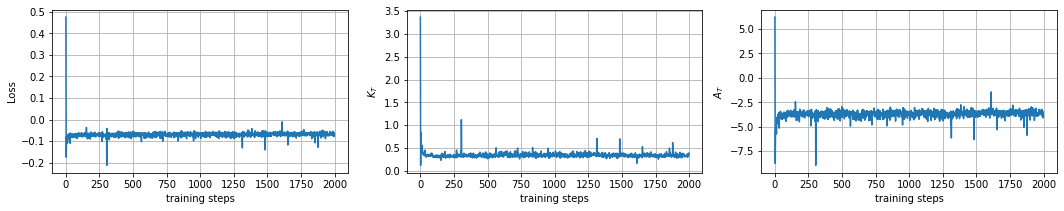

In [8]:
psi = np.array(Lambda).mean(1)
Girsanov = np.array(K).mean(1)
Current = np.array(A).mean(1)

fig, ax = plt.subplots(1,3, figsize=(18,3))
ax[0].plot(psi)
ax[1].plot(Girsanov)
ax[2].plot(Current)

ax[0].set_ylabel('Loss')
ax[1].set_ylabel(r'$K_T$')
ax[2].set_ylabel(r'$A_T$')

for i in range(3):
    ax[i].set_xlabel('training steps')
    ax[i].grid()
plt.show()